# 1. Setting up the enviroment

## Imports

In [1]:
%load_ext autoreload
%autoreload 1

import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import librosa as librosa
import librosa.display as display

import IPython.display as ipd

import numpy as np
from numpy import savetxt

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model

%aimport utils
su = utils

Using TensorFlow backend.


## Global variables

In [2]:
#artist
artist = "spec"

#sampling rate
sr = 22050

#min freq 
fmin = 20

#max freq
fmax = sr / 2 

#number of samples. 
#for music it is recommended 2048, but with 4096 we are getting better results
n_fft = 4096

#(columns) - so we can get 256 frames 
hop_length = 690
n_frames = 128*2

#(rows) - With this, we get nice 128 x 128 spectrograms 
n_mels = 128

#folder where the spectrograms are stored
spectrogram_folder_name='data/output/spectrograms/'

# 2. Read the spectrograms

In [3]:
file_list = su.get_file_list(spectrogram_folder_name, extension='png')
mel_spectrogram_array = su.get_spectrogram_array(file_list, n_mels, n_frames, spectrogram_folder_name, artist, from_file_list=True)

2750/2763 spectrograms processed


# 3. Train the network

## Parameters

In [4]:
code_dim = 64

epochs = 600

batch_size = 128

optimizer = 'adam'

loss = 'mse'

act_layer='relu'

act_last_layer='sigmoid'

model_name = 'classical_nn_2763_{}.h5'.format(code_dim)
code_name = 'classical_nn_2763_{}.csv'.format(code_dim)

## Datasets

In [5]:
print(mel_spectrogram_array.shape[0], " spectrograms (", n_mels, ",", n_frames, ")", sep='')
print ("Mel - Min:", np.amin(mel_spectrogram_array), "Max:", np.amax(mel_spectrogram_array))

#np.random.shuffle(mel_spectrogram_array)
x_train, x_test = su.split_dataset(mel_spectrogram_array, percentage_train=0.80)

print(len(x_train), "for training,", len(x_test), "for testing")

2763 spectrograms (128,256)
Mel - Min: 0.0 Max: 1.0
Train: [0,2210)
 Test: [2210,2763)
2210 for training, 553 for testing


## Topology

In [6]:
inputs = Input(shape=(n_mels*n_frames,))



encoded = Dense(n_mels*n_frames//32, activation=act_layer) (inputs)
#encoded = Dropout(0.2)(encoded)

encoded = Dense(n_mels*n_frames//64, activation=act_layer) (encoded)
#encoded = Dropout(0.2)(encoded)

encoded = Dense(code_dim, activation=act_layer) (encoded)



decoded = Dense(n_mels*n_frames//64, activation=act_layer)(encoded)
#decoded = Dropout(0.2)(decoded)

decoded = Dense(n_mels*n_frames//32, activation=act_layer)(decoded)
#decoded = Dropout(0.2)(decoded)

decoded = Dense(n_mels*n_frames, activation=act_last_layer)(decoded)



autoencoder_mod = Model(inputs, decoded)
autoencoder_mod.compile(optimizer=optimizer, loss=loss)

autoencoder_mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 32768)             3358

## Training

In [7]:
import time
start_time = time.time()

history = autoencoder_mod.fit(x_train, x_train,
               epochs = epochs,
               batch_size = batch_size,
               validation_data=(x_test, x_test),
               verbose=1)

print("--- %s seconds ---" % (time.time() - start_time))

Train on 2210 samples, validate on 553 samples
Epoch 1/600
2210/2210 [==============================] - 3s 1ms/step - loss: 0.0327 - val_loss: 0.0256
Epoch 2/600
2210/2210 [==============================] - 2s 786us/step - loss: 0.0234 - val_loss: 0.0222
Epoch 3/600
2210/2210 [==============================] - 2s 800us/step - loss: 0.0208 - val_loss: 0.0208
Epoch 4/600
2210/2210 [==============================] - 2s 973us/step - loss: 0.0192 - val_loss: 0.0196
Epoch 5/600
2210/2210 [==============================] - 2s 809us/step - loss: 0.0181 - val_loss: 0.0171
Epoch 6/600
2210/2210 [==============================] - 2s 694us/step - loss: 0.0168 - val_loss: 0.0166
Epoch 7/600
2210/2210 [==============================] - 2s 722us/step - loss: 0.0153 - val_loss: 0.0154
Epoch 8/600
2210/2210 [==============================] - 2s 732us/step - loss: 0.0146 - val_loss: 0.0163
Epoch 9/600
2210/2210 [==============================] - 2s 703us/step - loss: 0.0147 - val_loss: 0.0149
Epoch 10/6

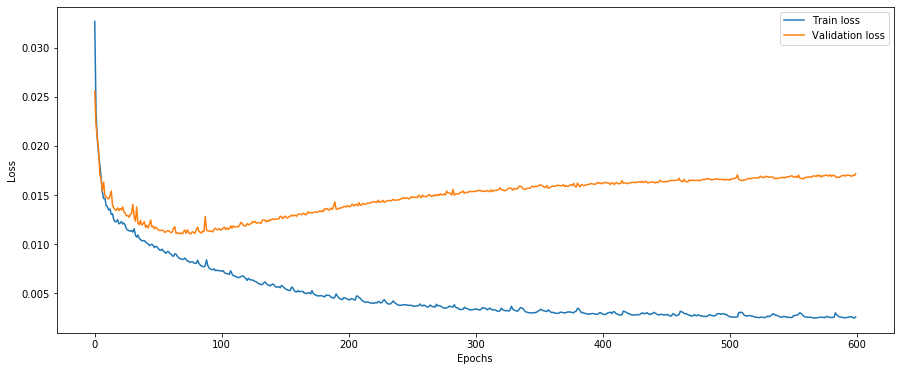

In [8]:
plt.figure(figsize=[15,6])

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Save model

In [9]:
autoencoder_mod.save(model_name)

# 4. Use the network

## Split the network into encoder and decoder

In [10]:
autoencoder_mod = load_model(model_name)

In [11]:
input_encoder = Input(shape=(n_mels*n_frames,))
encoder = autoencoder_mod.layers[1] (input_encoder)
encoder = autoencoder_mod.layers[2] (encoder)
encoder = autoencoder_mod.layers[3] (encoder)

encoder_mod = Model(input_encoder, encoder)
encoder_mod.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
Total params: 34,113,088
Trainable params: 34,113,088
Non-trainable params: 0
_________________________________________________________________


In [12]:
input_decoder = Input(shape=(code_dim,))
decoder = autoencoder_mod.layers[4] (input_decoder)
decoder = autoencoder_mod.layers[5] (decoder)
decoder = autoencoder_mod.layers[6] (decoder)

decoder_mod = Model(input_decoder, decoder)
decoder_mod.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 32768)             33587200  
Total params: 34,145,792
Trainable params: 34,145,792
Non-trainable params: 0
_________________________________________________________________


In [13]:
input_full = Input(shape=(n_mels*n_frames,))
encoded = encoder_mod(input_full)
decoded = decoder_mod(encoded)
autoencoder_seq = Model(input_full,decoded)
autoencoder_seq.compile(optimizer=optimizer, loss=loss)
autoencoder_seq.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32768)             0         
_________________________________________________________________
model_2 (Model)              (None, 64)                34113088  
_________________________________________________________________
model_3 (Model)              (None, 32768)             34145792  
Total params: 68,258,880
Trainable params: 68,258,880
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder_seq.evaluate(x_train, x_train)

2210/2210 [==============================] - 1s 365us/step


0.002710948591605166

## Save the code values

In [15]:
code_full = encoder_mod.predict(np.reshape(mel_spectrogram_array,(mel_spectrogram_array.shape[0],-1)))
savetxt(code_name, code_full, delimiter=',')

## Info about code vector

In [16]:
print (code_dim - np.count_nonzero(np.sum(code_full, axis=0)), "elements are set to zero")

27 elements are set to zero


# Sanity check

In [17]:
x = x_train
element = np.random.randint(0,len(x))
#element = 96
#element = 304
print("Clip num.", element)


code = encoder_mod.predict(np.reshape(x[element],(1,-1)))
print ("X - Min:", np.amin(code), "Max:", np.amax(code))

noise = np.random.normal(0, np.amax(code)/12, [1,code_dim]) 
#code = code+noise
decoded_data = decoder_mod.predict(code)

Clip num. 414
X - Min: 0.0 Max: 43.096565


In [18]:
#x = x_train

#decoded_data = autoencoder_mod.predict(np.reshape(x[element],(1,-1)))

## Recover audio from original spectrogram

In [19]:
mel_orig, y_orig = su.spectrogram_to_audio(x[element],n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

## Recover audio from generated spectrogram

In [20]:
mel_ae, y_ae = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

## Check everything is OK

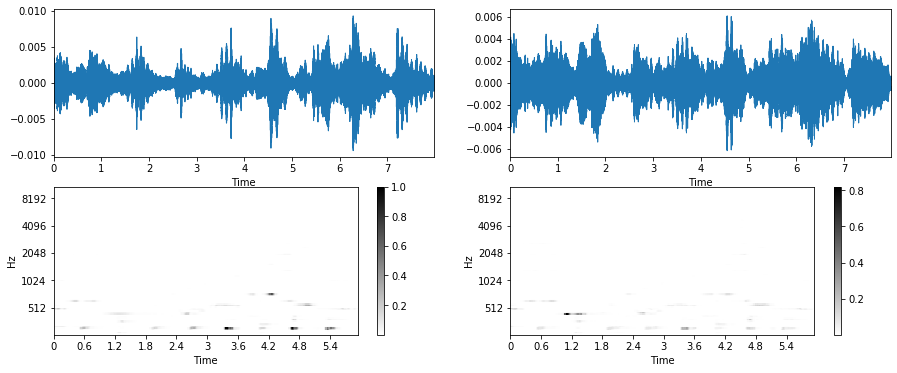

In [21]:
plt.figure(figsize=[15,6])

plt.subplot(2, 2, 1)
librosa.display.waveplot(y_orig);

plt.subplot(2, 2, 2)
librosa.display.waveplot(y_ae);

plt.subplot(2, 2, 3)
librosa.display.specshow(mel_orig, x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
plt.colorbar()

plt.subplot(2, 2, 4)
librosa.display.specshow(mel_ae, x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
plt.colorbar()

In [22]:
ipd.Audio(y_orig, rate=sr)

In [23]:
ipd.Audio(y_ae, rate=sr)